In [1]:

#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


#from UCLSE.supply_demand_mod import SupplyDemand
from UCLSE.message_supply_demand import SupplyDemand
from UCLSE.messenger import Messenger
from UCLSE.custom_timer import CustomTimer
from UCLSE.exchange import Order
from UCLSE.plotting_utilities import collect_orders, bid_ask_window#
from UCLSE.plotting_utilities import demand_curve_intersect,crude_plot
from UCLSE.plotting_utilities import plot_min_max_mean

In [2]:
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
animation.writers._registered['ffmpeg']==FFMpegWriter

True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Trader Parameters

The SupplyDemand Class distinguishes between buy and sell traders. This is simply  to aid with the conceptualisation of supply and demand within the simulation, the traders are otherwise identical and a buy trader could execute a sell order if it was given one.

Here for exposition, I've created a trader class from scratch.

We are considering the world where there are 50 buyer and 50 sellers

In [4]:
class dummy_trader():
    def __init__(self):
        pass
    
    def add_order(self, order, verbose,inform_exchange=False):
        return ('Proceed',None)

n_sellers=50
n_buyers=50    

traders={**{'B'+str(i): dummy_trader() for i in range(n_buyers)},
         **{'S'+str(i): dummy_trader() for i in range(n_sellers)}}

# Price parameters

We specify the  price range over which supply (ask) order and demand (bid) orders are generated. The option 'fixed' equally divides the price range by the number of traders of that type. Other options include 'jittered' which adds some noise to the equal spaced prices and 'random' which draws the prices uniformly randomly from the interval.

We can see this in the getorderprices method within the SupplyDemand class.

In [5]:
supply_price_low=80
supply_price_high=220

demand_price_low=80
demand_price_high=220

stepmode='fixed'

# Time parameters

These parameters refer to when orders are sent out to traders. 

In [6]:
timemode='drip-jitter' #alternatives drip periodic -all orders issued at same time., drip fixed - equally spaced
start=0
end=50
step=1

interval=step/(n_sellers+n_buyers)

This is just a helper function to allow us to get the input parameters into the right format for the supply and demand 'schedules'

In [7]:
def set_schedule(start,end,stepmode,range_low=0,range_high=0,offsetfn=None,offsetfn_max=None):
        
        if offsetfn is None:
            ranges=(range_low,range_high)
        else:
            if offsetfn_max is not None:
                ranges=(range_low,range_high,offsetfn,offsetfn_max)
            else:
                ranges=(range_low,range_high,offsetfn)
        return {'from':start,'to':end,
        'stepmode':stepmode,'ranges':ranges}

In [8]:
supply_schedule=[set_schedule(start,end,stepmode,range_low=supply_price_low,range_high=supply_price_high)]
demand_schedule=[set_schedule(start,end,stepmode,range_low=demand_price_low,range_high=demand_price_high)]

In [9]:
timer=CustomTimer(0,50,interval)
messenger=Messenger(logging=True)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,messenger=messenger,
			traders=traders,timer=timer,fit_to_interval=True)


In [10]:
order_store,order_count,order_dic=sd.collect_orders()


Order store is just a dataframe containing all orders created during the experiment

In [11]:
order_store.head(10)

,tid,otype,price,qty,qid,oid
time,,,,,,
0.03,B5,Bid,94.0,1,None,-7
0.03,S38,Ask,189.0,1,None,-90
0.04,B37,Bid,186.0,1,None,-39
0.05,S21,Ask,140.0,1,None,-73
0.06,B21,Bid,140.0,1,None,-23
0.07,S16,Ask,126.0,1,None,-68
0.08,B4,Bid,91.0,1,None,-6
0.09,S7,Ask,100.0,1,None,-59
0.11,B28,Bid,160.0,1,None,-30


Order_count is the number of orders generated during an interval

In [12]:
order_count.tail(10)

49.91    1
49.92    1
49.93    2
49.94    0
49.95    0
49.96    0
49.97    2
49.98    0
49.99    1
50.00    1
dtype: int64

We can see the slightly stochastic emission of orders over the period by plotting a rolling window sum

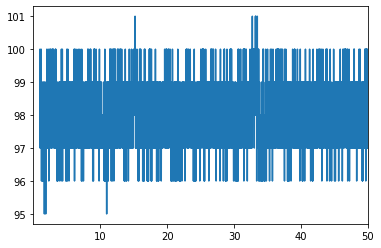

In [13]:

order_count.rolling(100).sum().plot()

We can divide bids and asks up over time windows, and then calculate demand and supply curves as well as their intersection

In [14]:
bids,asks,intersect=sd.bid_ask_window(order_store,periods=100)

bids and asks are both lists of dataframes containing orders from succesive time windows. Intersect is the approximate price at which demand=supply at those times.

In [15]:
intersect.head(10)

,intersect
time,
0.98,150.0
1.98,147.5
2.97,150.0
3.99,147.5
4.98,147.5
5.99,151.0
6.99,149.0
7.99,150.0
8.98,149.0


We can plot this crudely:

KeyboardInterrupt: 

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

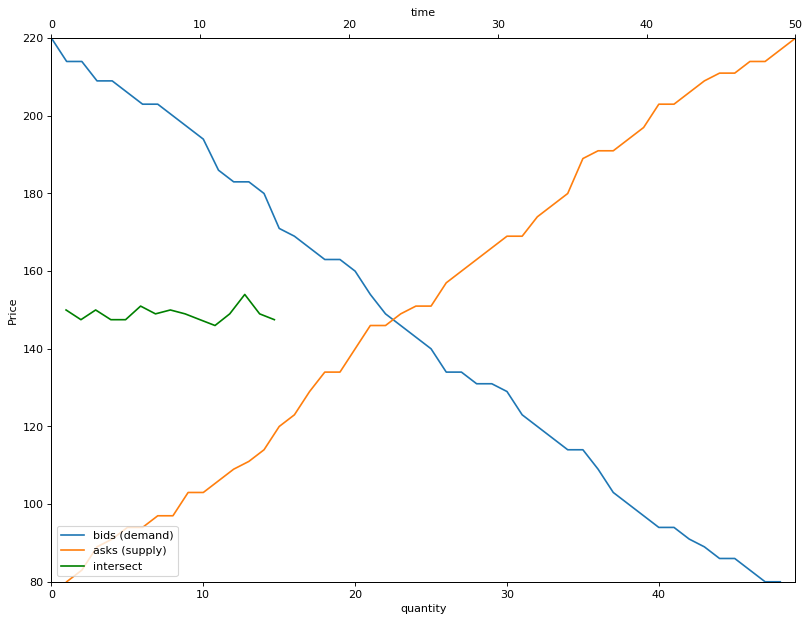

In [16]:
crude_plot(bids,asks,intersect)

Or if we have the correct codecs in place

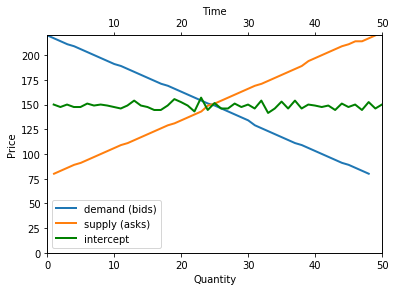

In [17]:
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

The intercept line is roughly stable over time. This is because the price ranges of the buyers and sellers are equal over time and the rate of emission of orders is roughly constant over time. 

# Time varying price 1: time varying price function

The module allows two ways of varying price over time. 

Firstly we can define an offset function which varies with time. This is added to the price range at every period, thereby translating the order price.

This could be used to incorporate real price data.

Here is an example:

In [18]:
def schedule_offsetfn_wrapper(wavelength,gradient=0,amplitude=50):

    def schedule_offsetfn(t): #weird function that affects price as a function of t
        pi2 = np.pi * 2
        periods=len(t)
        offset = gradient + amplitude * np.sin(pi2*wavelength/periods * t)
        ans=np.round(offset,0)

        return  ans
    
    return schedule_offsetfn

This is the output of the offset function.

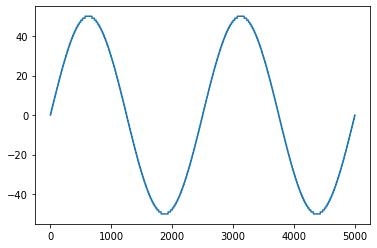

In [19]:
f=schedule_offsetfn_wrapper(2,gradient=0,amplitude=50)
plt.plot(f(np.arange(0,(end-start)/interval)))

In [20]:
offset_fn=schedule_offsetfn_wrapper(wavelength=2,gradient=0,amplitude=50)

messenger=Messenger()

#define price ranges
supply_price_low=80
supply_price_high=220

demand_price_low=80
demand_price_high=220

stepmode='fixed'

supply_schedule=[set_schedule(start,end,stepmode,range_low=supply_price_low,range_high=supply_price_high,offsetfn=offset_fn)]
demand_schedule=[set_schedule(start,end,stepmode,range_low=demand_price_low,range_high=demand_price_high,offsetfn=offset_fn)]

timer=CustomTimer(0,50,interval)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,
			traders=traders,timer=timer,fit_to_interval=False,messenger=messenger)

order_store,order_count,orders_dic=collect_orders(sd)


We can see this by looking at rolling averages in the dataframe of all orders emitted

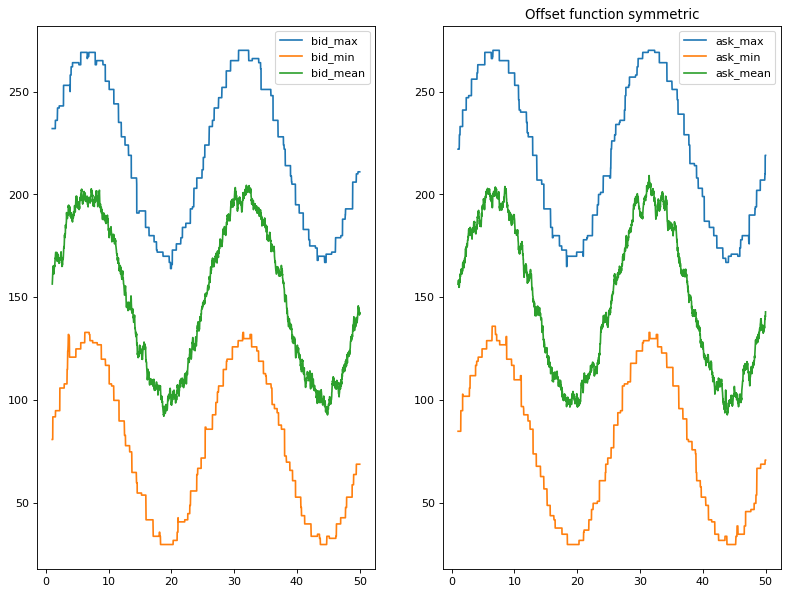

In [21]:
plot_min_max_mean(order_store,title='Offset function symmetric',rolling=50)

The video of the demand and supply curve development is a bit more exciting now

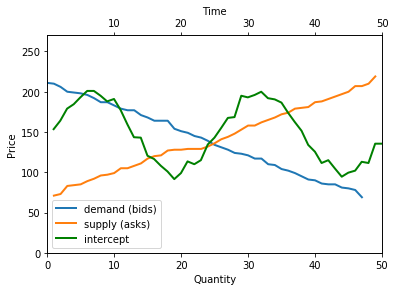

In [22]:
bids,asks,intersect=bid_ask_window(sd,order_store,periods=100)
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

In [25]:
fig.savefig('supplydemandtest.png',bbox_inches='tight')

equally can also supply two offset functions for the supply and demand

In [36]:
#define price ranges
supply_price_low=80
supply_price_high=220

demand_price_low=80
demand_price_high=220

stepmode='fixed'

#define offset functions
off_supply=schedule_offsetfn_wrapper(wavelength=2,gradient=0,amplitude=50)
off_demand=schedule_offsetfn_wrapper(wavelength=4,gradient=0,amplitude=50)

supply_schedule=[set_schedule(start,end,stepmode,range_low=supply_price_low,range_high=supply_price_high,offsetfn=off_supply)]
demand_schedule=[set_schedule(start,end,stepmode,range_low=demand_price_low,range_high=demand_price_high,offsetfn=off_demand)]

timer=CustomTimer(0,50,interval)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,
			traders=traders,timer=timer,fit_to_interval=False)

order_store,order_count,orders_dic=collect_orders(sd)

And plot this to show the two different frequencies in supply and demand

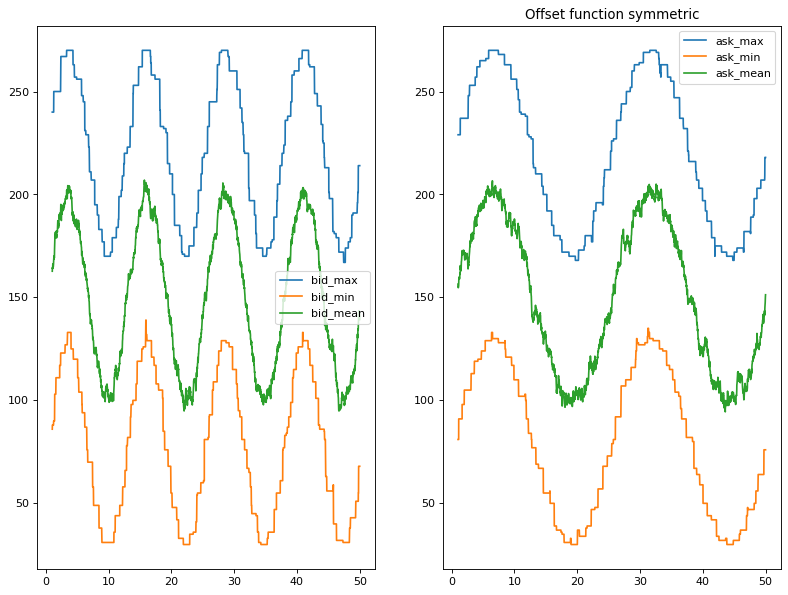

In [37]:
plot_min_max_mean(order_store,title='Offset function symmetric',rolling=50)

The dynamics of the intersect get more interesting

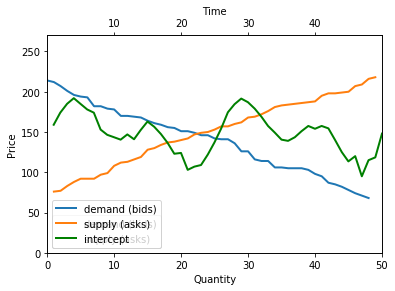

In [38]:
bids,asks,intersect=bid_ask_window(sd,order_store,periods=100)
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

We can even apply different offset functions to the minimum and maximum of the price range

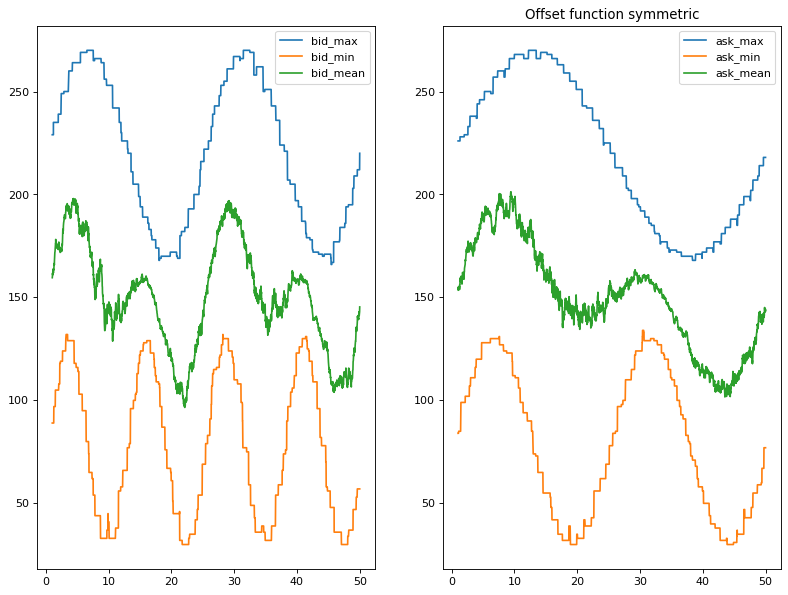

In [40]:
#define price ranges
supply_price_low=80
supply_price_high=220

demand_price_low=80
demand_price_high=220

stepmode='fixed'

#define offset functions
off_supply_min=schedule_offsetfn_wrapper(wavelength=2,gradient=0,amplitude=50)
off_supply_max=schedule_offsetfn_wrapper(wavelength=1,gradient=0,amplitude=50)
off_demand_min=schedule_offsetfn_wrapper(wavelength=4,gradient=0,amplitude=50)
off_demand_max=schedule_offsetfn_wrapper(wavelength=2,gradient=0,amplitude=50)

supply_schedule=[set_schedule(start,end,stepmode,range_low=supply_price_low,
                              range_high=supply_price_high,offsetfn=off_supply_min,
                              offsetfn_max=off_supply_max)]
demand_schedule=[set_schedule(start,end,stepmode,range_low=demand_price_low,
                              range_high=demand_price_high,offsetfn=off_demand_min,offsetfn_max=off_demand_max)]

timer=CustomTimer(0,50,interval)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,
			traders=traders,timer=timer,fit_to_interval=False)

order_store,order_count,orders_dic=collect_orders(sd)
plot_min_max_mean(order_store,title='Offset function symmetric',rolling=50)

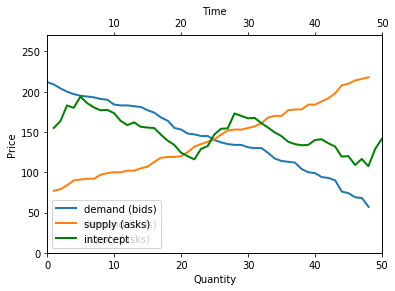

In [41]:
bids,asks,intersect=bid_ask_window(sd,order_store,periods=100)
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

# Time varying price 2: Regime changes

Alternatively, or additionally we can specify different regimes for demand and supply over time. This is done by feeding the supplydemand init method a list of demand and supply schedules. This can be acheived by defining the price and time ranges as lists.

In [43]:

  
#define price ranges and time ranges for them
supply_price_low=[80,100,100]
supply_price_high=[220,150,150]
s_start=[0,25,40]
s_end=[25,40,50]

demand_price_low=[80,60,80]
demand_price_high=[220,100,220]
d_start=[0,15,40]
d_end=[15,40,50]

stepmode='fixed'


supply_schedule=[set_schedule(s,e,stepmode,range_low=spl,range_high=sph)
                 for s,e,spl,sph in zip(s_start,s_end,supply_price_low,supply_price_high)]


demand_schedule=[set_schedule(s,e,stepmode,range_low=dpl,range_high=dph)
                for s,e,dpl,dph in zip(d_start,d_end,demand_price_low,demand_price_high)]

timer=CustomTimer(0,50,interval)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,
			traders=traders,timer=timer,fit_to_interval=False)

order_store,order_count,orders_dic=collect_orders(sd)

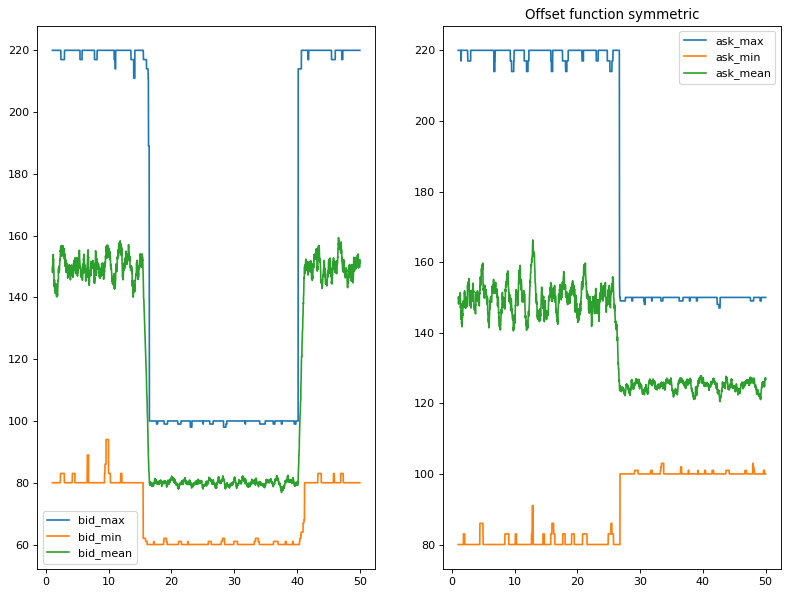

In [44]:
plot_min_max_mean(order_store,title='Offset function symmetric',rolling=50)

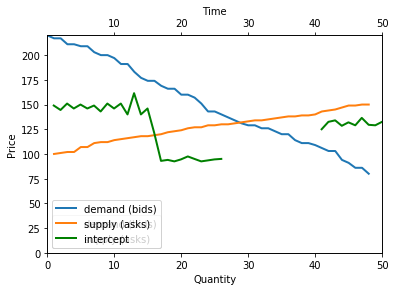

In [45]:
bids,asks,intersect=bid_ask_window(sd,order_store,periods=100)
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

# Varying order quantity

The original BSE only had capability to handle unit quantity orders. This is quite common across research papers since in theory unit trades can recreate larger trades. When considering spoofing it is necessary to allow larger orders. Moreover since heterogenous sized orders occur in real life, any model we build should admit them.

In the first instance, we have allowed the user to define a random quantity function which is called when orders are created. 

As an extension, we could make the distribution of this function price dependent.

In [46]:
def geometric_wrap(freq):
    def geometric_q():
        return np.random.geometric(freq)
    return geometric_q

Just pass the quantity function with argument 'quantity_f'

In [47]:
geometric_q=geometric_wrap(0.6)


#define price ranges
supply_price_low=80
supply_price_high=220

demand_price_low=80
demand_price_high=220

stepmode='fixed'

supply_schedule=[set_schedule(start,end,stepmode,range_low=supply_price_low,range_high=supply_price_high)]
demand_schedule=[set_schedule(start,end,stepmode,range_low=demand_price_low,range_high=demand_price_high)]

timer=CustomTimer(0,50,interval)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,
			traders=traders,timer=timer,fit_to_interval=False,quantity_f=geometric_q)

order_store,order_count,orders_dic=collect_orders(sd)

And we can see this is how it has distributed order quantity:

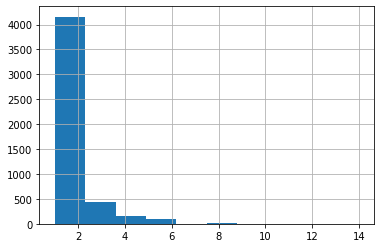

In [48]:
order_store.qty.hist()

The balancing point of supply and demand won't change since the quantity distribution is static across supply,demand and price. 

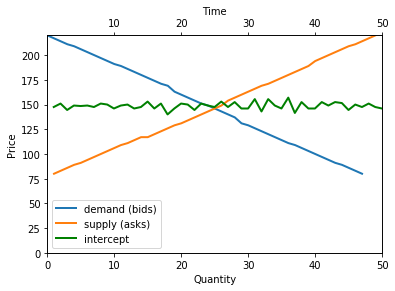

In [67]:
bids,asks,intersect=bid_ask_window(sd,order_store,periods=100)
fig,h=demand_curve_intersect(bids,asks,intersect,order_store)
h

# Supply demand object sending orders to traders

- The SD object sends orders to traders by means of the do_dispatch method through the messenger.
- orders are retrieved from sd.order_dic
- This is a time indexed dictionary of order lists. 
- This is set before an experiment begins through use of set_orders method

In [62]:
timer=CustomTimer(0,50,interval)
messenger=Messenger(logging=True,asserting=False)
sd=SupplyDemand(supply_schedule=supply_schedule,demand_schedule=demand_schedule,
			interval=1,timemode=timemode,pending=None,n_buyers=n_buyers,n_sellers=n_sellers,messenger=messenger,
			traders=traders,timer=timer,fit_to_interval=True)
sd.set_orders()


In [63]:
while timer.next_period():
    print(timer.time)
    if sd.order_dic[timer.time]!=[]:break


for new_order in sd.order_dic[sd.time]:
    print(new_order)
    sd.do_dispatch(new_order)

0.01
0.02
Order(tid='B32', otype='Bid', price=171.0, qty=1, time=0.014, qid=None, oid=-34)
Recipient not subscribed: B32


C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\messenger.py:55: UserWarning: Asserting is set to False for messenger object: Cannot guarantee messages will be sent or received
  warnings.warn(m,UserWarning)
C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\messenger.py:93: UserWarning: Dummy object being used to receive message
  warnings.warn(m,UserWarning)


In [66]:
messenger.publish_log(0.02)

,fromm,too,subject,time,order
0,SD1,B32,New Customer Order,0.02,"(B32, Bid, 171.0, 1, 0.014, None, -34)"
